In [25]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchattacks import *

from utils import *

from tqdm import tqdm
# from utils import imshow, image_folder_custom_label

In [2]:
Batch_size = 200
thr = 10000

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
# transform = transforms.Compose(
#         [
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ]
#     )
# val_dataset = torchvision.datasets.ImageNet(root="./dataset", split='val',transform=transform)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=5)

In [16]:
from loader_sampler import *
transform = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
#                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

train_dataset = random_sampler(root="/home/h2amer/AhmedH.Salamah/ilsvrc2012", t_split='train',transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_size, shuffle=True, num_workers=28)

# load model

In [9]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [10]:
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [11]:
model = nn.Sequential(
    norm_layer,
    models.resnet18(pretrained=True)
).to(device)
model = model.eval()

In [ ]:
# transform = transforms.Compose(
#         [
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ]
#     )
# train_dataset = torchvision.datasets.ImageNet(root="./dataset", split='train',transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=5)

In [12]:
atk = FGSM(model, eps=8/255)
atk = CW(model, c=1, lr=0.01, steps=100, kappa=0)

In [17]:
idx = 0
Y_sen_list = np.empty([0, 8, 8])
Cb_sen_list = np.empty([0, 8, 8])
Cr_sen_list = np.empty([0, 8, 8])

for images, labels in tqdm(train_loader):
    img_shape = images.shape[-2:]
    images, labels = images.to(device), labels.to(device)
    # generate adv images
    adv_images = atk(images, labels)
    # adv_images = images
    # DCT 
    ycbcr_adv_images = rgb_to_ycbcr(adv_images)
    input_adv_DCT_block_batch = block_dct(blockify(ycbcr_adv_images, 8))
    input_adv_DCT_block_batch.requires_grad = True
    recoverd_adv_img = deblockify(block_idct(input_adv_DCT_block_batch), (img_shape[0], img_shape[1]))
    # feed the attack to DNN
    outputs = model(ycbcr_to_rgb(recoverd_adv_img))
    _, pre = torch.max(outputs.data, 1)
    loss = torch.nn.CrossEntropyLoss()(outputs, pre)
    model.zero_grad()
    loss.backward()
    data_grad = torch.mean(torch.abs(input_adv_DCT_block_batch.grad), dim = 2).transpose(1,0).detach().cpu().numpy()
    Y_sen_list = np.concatenate((Y_sen_list, data_grad[0].reshape(-1, 8, 8)))
    Cb_sen_list = np.concatenate((Cb_sen_list, data_grad[1].reshape(-1, 8, 8)))
    Cr_sen_list = np.concatenate((Cr_sen_list, data_grad[2].reshape(-1, 8, 8)))
    idx += Batch_size
    if idx >= thr:
        break

  2%|██▏                                                                                                                                            | 99/6406 [16:07<17:07:39,  9.78s/it]


In [48]:
def plot_save_senmap(sen_img, ch="Y", model="Resnet"):
#     sen_img = sen_img[:10000,:,:]

    print("size : ", np.shape(Y_sen_list))
    
    zigzag = get_zigzag()
    lst_length = sen_img.shape[0]
    zigzag_sen_img = np.zeros((64,lst_length))
    for i in range(8):
        for j in range(8):
            zigzag_sen_img[zigzag[i,j]] = sen_img[:,i,j]
    del sen_img
    
    bottom_lst = []
    top_lst = []
    mean_lst = []
    # figure(figsize=(10, 8), dpi=1024)
    for i in tqdm(range(64)):
        bottom,top = list(bootstrap((zigzag_sen_img[i],), np.mean, confidence_level=0.95,n_resamples=10).confidence_interval)
        mean = np.mean((bottom,top))
        bottom_lst.append(bottom)
        top_lst.append(top)
        mean_lst.append(mean)
    plt.figure(figsize=(10,8))
    plt.plot(bottom_lst)
    plt.plot(top_lst)
    plt.plot(mean_lst)
    
    plt.xticks(np.arange(1,65,4))
    plt.title(ch+' channel L1 sensitivity, per image')
    plt.savefig(ch+model+".pdf")
    plt.figure().clear()
    return top_lst, mean_lst, bottom_lst


size :  (20000, 8, 8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [02:08<00:00,  2.01s/it]


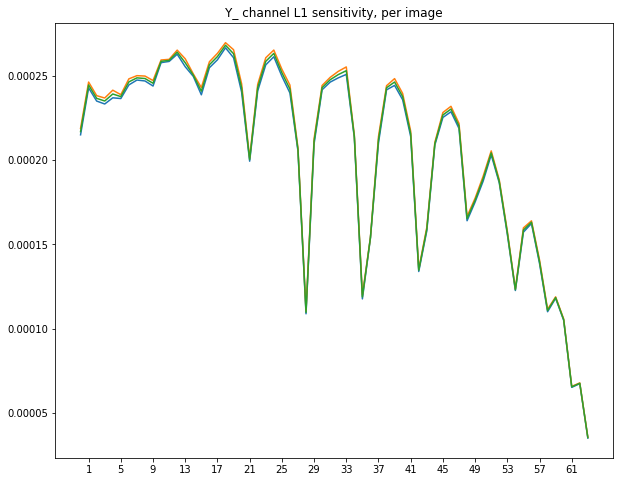

<Figure size 432x288 with 0 Axes>

In [49]:
top_lst_Y, mean_lst_Y, bottom_lst_Y = plot_save_senmap(Y_sen_list, "Y_", "Resnet18")
# top_lst_Cb, mean_lst_Cb, bottom_lst_Cb = plot_save_senmap(Cb_sen_list, "Cb_", "Resnet18")
# top_lst_Cr, mean_lst_Cr, bottom_lst_Cr = plot_save_senmap(Cr_sen_list, "Cr_", "Resnet18")

In [28]:
np.shape(Y_sen_list)

(20000, 8, 8)

In [22]:
top_lst_Y_adv, mean_lst_Y_adv, bottom_lst_Y_adv = plot_save_senmap(Y_sen_list, "Y_adv_", "Resnet18")
# top_lst_Cb_adv, mean_lst_Cb_adv, bottom_lst_Cb_adv = plot_save_senmap(Cb_sen_list, "Cb_adv_", "Resnet18")
# top_lst_Cr_adv, mean_lst_Cr_adv, bottom_lst_Cr_adv = plot_save_senmap(Cr_sen_list, "Cr_adv_", "Resnet18")

 23%|██████████████████████████████████▋                                                                                                                 | 15/64 [00:31<01:44,  2.13s/it]


ValueError: Percentiles must be in the range [0, 100]

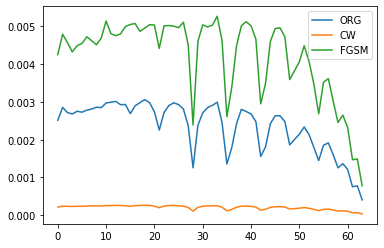

In [47]:
ymean = [0.0025150925192657806, 0.002856051030918112, 0.0027182311044685412, 0.0026817611542513603, 0.0027542112971579626, 0.0027289270645300817, 0.0027833326917527206, 0.002810700338728468, 0.0028608179508539345, 0.002848188513790775, 0.0029730675588594616, 0.002993082178203898, 0.003014514211320849, 0.00292685201503058, 0.002932601876068601, 0.0026893966245010613, 0.0028960907768760683, 0.002982167075680091, 0.0030611931562291687, 0.0029806554799218146, 0.0027401268607158275, 0.002255494565599985, 0.0027227859439711575, 0.0029051811163511325, 0.002978054328917276, 0.0029298044961224502, 0.0028121117048751417, 0.002366326380844103, 0.0012568919263465463, 0.002379472902650764, 0.0027105743872455875, 0.0028484403685875045, 0.0029089582012470604, 0.002993170401868985, 0.002453406983893679, 0.0013576293317523426, 0.0017837145958592275, 0.0024257360979498925, 0.002804031568595695, 0.0027475732724782462, 0.0026808371956012138, 0.002481332825484362, 0.0015557642294633067, 0.0018102514000054482, 0.002424866117297247, 0.002635708923089254, 0.0026337765827140784, 0.002481377091235319, 0.0018634419983828865, 0.0020078929294883602, 0.0021460146295749103, 0.0023378567145918476, 0.0021382150774120006, 0.0017979398225631315, 0.0014482054204036727, 0.0018536755424334752, 0.0019162741407453112, 0.0016032907474078971, 0.001254572551732435, 0.0013644165506928184, 0.0012116516058172698, 0.0007540887152200062, 0.0007791426036605773, 0.0004067061850837884]
Y_adv_fgsm = [0.004255530534018637, 0.004791848715650927, 0.004571132552082969, 0.004324729708171666, 0.004488966418478122, 0.004549450968388772, 0.0047250297392073745, 0.004623014108154016, 0.004513635063358654, 0.004690368347590951, 0.0051421461234177615, 0.004807109816077175, 0.004754826982504063, 0.004802762587729312, 0.004997519755429767, 0.005049852948465302, 0.005077172641450041, 0.004870293042772643, 0.004955053026593034, 0.0050455598328785775, 0.005036496440572265, 0.004414969583334051, 0.005016619390709118, 0.005022573640486444, 0.005007183660142087, 0.004966360861708943, 0.005109514208104683, 0.004506218894165137, 0.002389453651564106, 0.004599797752354346, 0.005042185933188088, 0.004984980302533564, 0.005033042739520502, 0.005269021849403406, 0.0046231571260224435, 0.0026097744145403955, 0.0033793129895015026, 0.004488188966823847, 0.005017900528961821, 0.005123648000335465, 0.005014676721048722, 0.0046640984069563525, 0.002949915044107554, 0.0034923678322105254, 0.0046002613030095875, 0.004944776860516521, 0.004960408740681597, 0.004726584750103251, 0.003592172305857829, 0.0038261965458887236, 0.004062591863022021, 0.004488780060289545, 0.00407433054269413, 0.003475648679713688, 0.0026854998036803055, 0.003520537316134783, 0.0036158834880195253, 0.0030227365338791057, 0.0024555498810658874, 0.0026506107795816443, 0.0023230398302452045, 0.0014693184238348568, 0.0014903900327167957, 0.000782773075710907]

plt.plot(ymean, label="ORG")
plt.plot(mean_lst_Y, label="CW")
plt.plot(Y_adv_fgsm, label="FGSM")
plt.legend()